In [1]:
from MALDIMap import MALDINet
from MALDIMap.utils import LoadMSData, SaveMpOrX, PlotCurve

import os
import math
import itertools
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from joblib import load, dump

from sklearn.metrics import recall_score,precision_score,confusion_matrix,roc_curve,balanced_accuracy_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, f1_score
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold,RepeatedStratifiedKFold, train_test_split
from aggmap import AggMap, AggMapNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='7'
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)    #动态调用GPU

In [3]:
root_path = '/raid/lzyt_dir/Data/'#质谱csv和标签路径
save_path = '/mnt/lzyt/SmallSamples'#mp和X保存路径

In [4]:
def FilterMassPeaks(df, min_count=None, min_freq=None):
    if min_count is None and min_freq is None:
        raise ValueError("At least one of 'min_count' and 'min_freq' must be provided.")
    elif min_count is not None and min_freq is not None:
        raise ValueError("Only one of 'min_count' and 'min_freq' can be provided.")
        
    # 计算每列中的非零值数量
    non_zero_counts = df.astype(bool).sum(axis=0)
    
    # 根据最小次数或最小频率筛选列
    if min_count is not None:
        filtered_cols = non_zero_counts[non_zero_counts >= min_count].index
    else:
        thresh = df.shape[0] * min_freq
        filtered_cols = non_zero_counts[non_zero_counts >= thresh].index
    
    return df[filtered_cols]

### 1.导入数据和标签

In [5]:
df = LoadMSData(root_path = root_path, data_path = 'data14/coli/peaks_all.csv', t = False)
df

,Maldi:2101.13,Maldi:2133.00,Maldi:2140.33,Maldi:2171.61,Maldi:2178.87,Maldi:2186.48,Maldi:2204.42,Maldi:2219.94,Maldi:2241.84,Maldi:2248.85,...,Maldi:8271.93,Maldi:8460.76,Maldi:8544.43,Maldi:8680.23,Maldi:9155.54,Maldi:9551.62,Maldi:9688.51,Maldi:10096.58,Maldi:10276.02,Maldi:10323.79
0,0.00,0.0,0.0,0.0,1525.46,0.0,0.00,0.0,3244.59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,824.43
1,0.00,0.0,0.0,0.0,2696.70,0.0,1179.06,0.0,5434.61,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1061.89
2,0.00,0.0,0.0,0.0,2268.61,0.0,0.00,0.0,4861.06,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,940.79
3,0.00,0.0,0.0,0.0,0.00,0.0,3068.13,0.0,3239.47,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,956.66
4,0.00,0.0,0.0,0.0,0.00,0.0,1361.98,0.0,2326.91,0.0,...,0.0,0.0,6167.4,0.0,0.0,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,4541.58,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1078.11
344,1680.89,0.0,0.0,0.0,3459.50,0.0,0.00,0.0,6062.55,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,624.72
345,0.00,0.0,0.0,0.0,2571.32,0.0,0.00,0.0,4279.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1246.74
346,0.00,0.0,0.0,0.0,3039.66,0.0,2284.41,0.0,5603.58,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,937.82


In [6]:
dfx = FilterMassPeaks(df, min_count=1)
dfx

,Maldi:2101.13,Maldi:2133.00,Maldi:2140.33,Maldi:2178.87,Maldi:2186.48,Maldi:2204.42,Maldi:2219.94,Maldi:2241.84,Maldi:2248.85,Maldi:2356.29,...,Maldi:6804.89,Maldi:6826.25,Maldi:7036.17,Maldi:7066.22,Maldi:7083.30,Maldi:8153.75,Maldi:8544.43,Maldi:9155.54,Maldi:10096.58,Maldi:10323.79
0,0.00,0.0,0.0,1525.46,0.0,0.00,0.0,3244.59,0.0,0.0,...,0.0,0.0,5934.74,0.0,6501.48,1470.52,0.0,0.0,0.0,824.43
1,0.00,0.0,0.0,2696.70,0.0,1179.06,0.0,5434.61,0.0,0.0,...,0.0,0.0,6537.38,0.0,8241.43,2081.77,0.0,0.0,0.0,1061.89
2,0.00,0.0,0.0,2268.61,0.0,0.00,0.0,4861.06,0.0,0.0,...,0.0,0.0,5077.99,0.0,5626.35,1605.89,0.0,0.0,0.0,940.79
3,0.00,0.0,0.0,0.00,0.0,3068.13,0.0,3239.47,0.0,0.0,...,1137.8,0.0,6116.07,0.0,3930.12,0.00,0.0,0.0,0.0,956.66
4,0.00,0.0,0.0,0.00,0.0,1361.98,0.0,2326.91,0.0,0.0,...,0.0,0.0,7328.36,0.0,5636.67,1351.30,6167.4,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,0.00,0.0,0.0,0.00,0.0,0.00,0.0,4541.58,0.0,0.0,...,0.0,0.0,7957.14,0.0,7066.99,1498.12,0.0,0.0,0.0,1078.11
344,1680.89,0.0,0.0,3459.50,0.0,0.00,0.0,6062.55,0.0,0.0,...,0.0,0.0,5576.95,0.0,5373.77,948.71,0.0,0.0,0.0,624.72
345,0.00,0.0,0.0,2571.32,0.0,0.00,0.0,4279.00,0.0,0.0,...,0.0,0.0,6041.96,0.0,6325.56,1034.99,0.0,0.0,0.0,1246.74
346,0.00,0.0,0.0,3039.66,0.0,2284.41,0.0,5603.58,0.0,0.0,...,0.0,0.0,6833.47,0.0,6610.50,1294.85,0.0,0.0,0.0,937.82


In [7]:
#Labels Loading 读入原始标签
Labels = pd.read_csv(r'/raid/lzyt_dir/Data/data14/coli/labels_all.csv',header=None)
Y = np.array(Labels)
#Multi-hot Labels Loading 生成训练标签
#S 0;Cip 1;Ery 2;Tet 3;Amp 4;Kana 5;Strep 6;Gent 7;
labelValue = {'S': 0,'Cip': 1, 'Ery': 2,'Tet': 3,'Amp': 4,'Kana': 5,'Strep': 6,'Gent': 7}
labels = ['Cip', 'Ery','Tet','Amp','Kana','Strep','Gent']
train_Y = np.zeros((348,8))

i = 0
for Label in Y:
    Label = Label[0]
    if(Label == 'S') :
        train_Y[i][0] = 1
    else :
        for label in labels:
            if(label in Label) :
                train_Y[i][labelValue[label]] = 1
    i = i + 1

Multi_y = train_Y.astype(int)

In [8]:
from sklearn.preprocessing import OneHotEncoder
one_hot_labels = []
for label, index in labelValue.items():
    Label_Y = Multi_y[:,index]
    # 创建一个OneHotEncoder对象
    encoder = OneHotEncoder(sparse=False)
    # 将labels转换为二维独热编码标签数组
    one_hot_label = encoder.fit_transform(Label_Y.reshape(-1, 1))
    one_hot_labels.append(one_hot_label)

### 2.生成特征图

In [9]:
mp = load('/mnt/lzyt/SmallSamples/data12/aggmap/aggmap_coli_mincount_1.mp')
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 348/348 [00:03<00:00, 89.13it/s]


### 3.模型训练测试（demo）

In [ ]:
#划分验证集并调整classweight
clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],units=[1, 6, 36],batch_size=64,epochs=20,metric = 'AUC',gpuid=5,verbose=0,printOrNot = True)
clf.fit(X_train, Y_train)
PlotCurve(clf.history)

y_pred = clf.predict(X_test)
print(Y_test[:,1].astype(int))
print(y_pred)
print('auc = ',roc_auc_score(Y_test[:,1],y_pred))

Epoch 1/25
6/6 - 2s - loss: 0.8653 - accuracy: 0.5353 - val_loss: 0.7753 - val_accuracy: 0.0959
Epoch 2/25
6/6 - 0s - loss: 0.6402 - accuracy: 0.6059 - val_loss: 0.7148 - val_accuracy: 0.5342
Epoch 3/25
6/6 - 0s - loss: 0.6792 - accuracy: 0.6706 - val_loss: 0.6640 - val_accuracy: 0.6027
Epoch 4/25
6/6 - 0s - loss: 0.6943 - accuracy: 0.6353 - val_loss: 0.5756 - val_accuracy: 0.6849
Epoch 5/25
6/6 - 0s - loss: 0.4961 - accuracy: 0.6941 - val_loss: 0.5275 - val_accuracy: 0.7534
Epoch 6/25
6/6 - 0s - loss: 0.4655 - accuracy: 0.7882 - val_loss: 0.4965 - val_accuracy: 0.7397
Epoch 7/25
6/6 - 0s - loss: 0.5148 - accuracy: 0.7824 - val_loss: 0.4510 - val_accuracy: 0.7808
Epoch 8/25
6/6 - 0s - loss: 0.5154 - accuracy: 0.7765 - val_loss: 0.4571 - val_accuracy: 0.7808
Epoch 9/25
6/6 - 0s - loss: 0.3558 - accuracy: 0.8412 - val_loss: 0.5047 - val_accuracy: 0.7397
Epoch 10/25
6/6 - 0s - loss: 0.3515 - accuracy: 0.8294 - val_loss: 0.4822 - val_accuracy: 0.8082
Epoch 11/25
6/6 - 0s - loss: 0.3734 - a

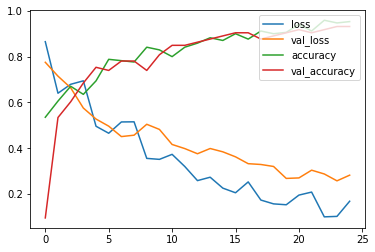

Confusion Matrix: 
[[90  5]
 [ 5  5]]
Validation Accuracy: 90.48%
Validation Sensitivity: 50.00%
Validation Specificity: 94.74%
Validation Balanced accuracy: 72.37%
Validation AUC: 0.8884


In [109]:
#划分验证集 自动调整classweight 找最佳参数
Y = Multi_y[:,7]
y = one_hot_labels[7]
Train_X, test_X, Train_Y, test_Y = train_test_split(X, y, test_size=0.3,stratify=y,random_state=0, shuffle=True)
test_y = test_Y[:,1]
train_X, val_X, train_Y, val_Y = train_test_split(Train_X, Train_Y, test_size=0.3,stratify=Train_Y,random_state=42, shuffle=True)

#model 
clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64,32],units=[4, 12, 12],batch_size=32,
                                   dropout=0.15,epochs=25,verbose=2,gpuid=7)
clf.fit(train_X, train_Y, X_val = val_X, y_val = val_Y,
        class_weights=dict(enumerate(class_weight.compute_class_weight('balanced', [0, 1], train_Y[:, 1]))))
y_pro = clf.predict_proba(test_X)
y_raw = 0 * y_pro[:, 0] + 1 * y_pro[:, 1]
y_pred = np.argmax(y_pro, axis=1)

#plot train curve
PlotCurve(clf.history)

#MADLINet Test Metrics
Overall_accuracy = accuracy_score(test_y, y_pred)
conf_matrix = confusion_matrix(test_y, y_pred,labels=[0,1])
Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
Balanced_accuracy = balanced_accuracy_score(test_y, y_pred)
AUC = roc_auc_score(test_y, y_raw)

print('Confusion Matrix: ')
print(conf_matrix)
print("Validation Accuracy: {:5.2f}%".format(Overall_accuracy*100))
print('Validation Sensitivity: {:5.2f}%'.format(Sensitivity*100))
print('Validation Specificity: {:5.2f}%'.format(Specificity*100))
print('Validation Balanced accuracy: {:5.2f}%'.format(Balanced_accuracy*100))
print('Validation AUC: {:5.4f}'.format(AUC))

## 保存一套参数

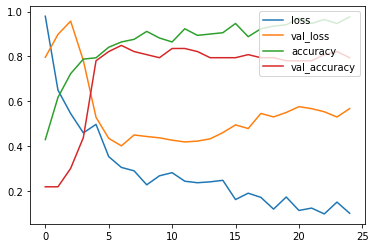

Confusion Matrix: 
[[74  8]
 [ 9 14]]
Validation Accuracy: 83.81%
Validation Sensitivity: 60.87%
Validation Specificity: 90.24%
Validation Balanced accuracy: 75.56%
Validation AUC: 0.7884


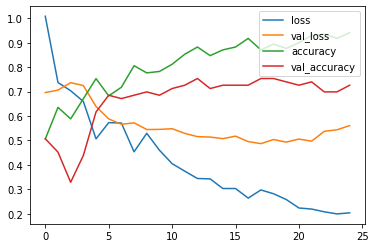

Confusion Matrix: 
[[38 13]
 [13 41]]
Validation Accuracy: 75.24%
Validation Sensitivity: 75.93%
Validation Specificity: 74.51%
Validation Balanced accuracy: 75.22%
Validation AUC: 0.8326


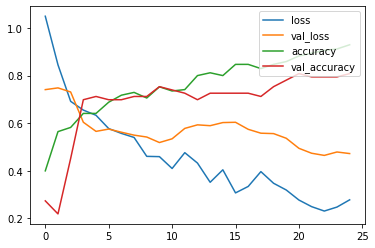

Confusion Matrix: 
[[65 12]
 [11 17]]
Validation Accuracy: 78.10%
Validation Sensitivity: 60.71%
Validation Specificity: 84.42%
Validation Balanced accuracy: 72.56%
Validation AUC: 0.7982


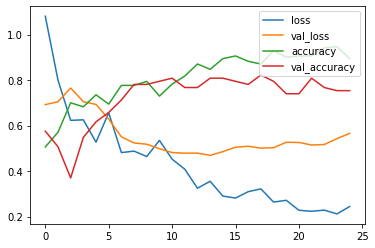

Confusion Matrix: 
[[28 14]
 [10 53]]
Validation Accuracy: 77.14%
Validation Sensitivity: 84.13%
Validation Specificity: 66.67%
Validation Balanced accuracy: 75.40%
Validation AUC: 0.8375


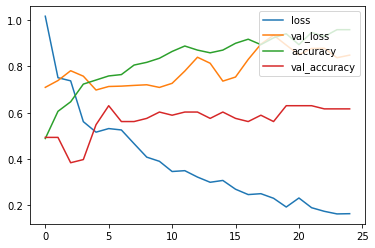

Confusion Matrix: 
[[32 20]
 [12 41]]
Validation Accuracy: 69.52%
Validation Sensitivity: 77.36%
Validation Specificity: 61.54%
Validation Balanced accuracy: 69.45%
Validation AUC: 0.7623


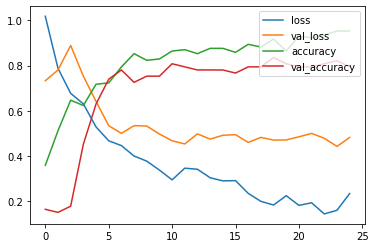

Confusion Matrix: 
[[78 11]
 [ 7  9]]
Validation Accuracy: 82.86%
Validation Sensitivity: 56.25%
Validation Specificity: 87.64%
Validation Balanced accuracy: 71.95%
Validation AUC: 0.7676


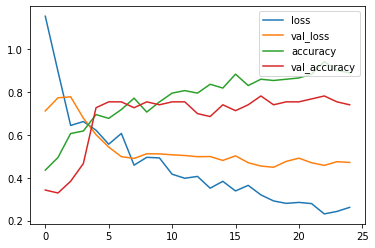

Confusion Matrix: 
[[55 18]
 [12 20]]
Validation Accuracy: 71.43%
Validation Sensitivity: 62.50%
Validation Specificity: 75.34%
Validation Balanced accuracy: 68.92%
Validation AUC: 0.7153


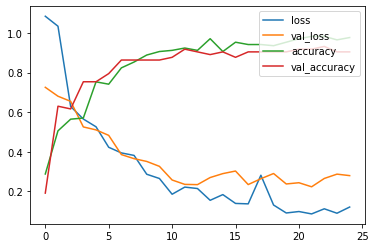

Confusion Matrix: 
[[88  7]
 [ 4  6]]
Validation Accuracy: 89.52%
Validation Sensitivity: 60.00%
Validation Specificity: 92.63%
Validation Balanced accuracy: 76.32%
Validation AUC: 0.8547


In [85]:
auc_scores = []
for i in range(len(one_hot_labels)):
    Y = Multi_y[:,i]
    y = one_hot_labels[i]
    Train_X, test_X, Train_Y, test_Y = train_test_split(X, y, test_size=0.3,stratify=y,random_state=0, shuffle=True)
    #划分验证集并调整classweight
    test_y = test_Y[:,1]
    train_X, val_X, train_Y, val_Y = train_test_split(Train_X, Train_Y, test_size=0.3,stratify=Train_Y,random_state=42, shuffle=True)

    #model 
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64,64],units=[4, 24, 24],batch_size=32,
                                       dropout=0.15,epochs=25,verbose=0,gpuid=7)
    clf.fit(train_X, train_Y, X_val = val_X, y_val = val_Y,
            class_weights=dict(enumerate(class_weight.compute_class_weight('balanced', [0, 1], train_Y[:, 1]))))
    y_pro = clf.predict_proba(test_X)
    y_raw = 0 * y_pro[:, 0] + 1 * y_pro[:, 1]
    y_pred = np.argmax(y_pro, axis=1)

    #plot train curve
    PlotCurve(clf.history)

    #MADLINet Test Metrics
    Overall_accuracy = accuracy_score(test_y, y_pred)
    conf_matrix = confusion_matrix(test_y, y_pred,labels=[0,1])
    Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
    Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    Balanced_accuracy = balanced_accuracy_score(test_y, y_pred)
    AUC = roc_auc_score(test_y, y_raw)
    auc_scores.append(AUC)

    print('Confusion Matrix: ')
    print(conf_matrix)
    print("Validation Accuracy: {:5.2f}%".format(Overall_accuracy*100))
    print('Validation Sensitivity: {:5.2f}%'.format(Sensitivity*100))
    print('Validation Specificity: {:5.2f}%'.format(Specificity*100))
    print('Validation Balanced accuracy: {:5.2f}%'.format(Balanced_accuracy*100))
    print('Validation AUC: {:5.4f}'.format(AUC))

In [86]:
valueLabel = {value: key for key, value in labelValue.items()}
for i in range(len(auc_scores)):
    print(f'{valueLabel.get(i)} auc is {auc_scores[i]}')
print('Mean AUC = ',np.mean(auc_scores))

S auc is 0.788441145281018
Cip auc is 0.8326071169208424
Ery auc is 0.7982374768089053
Tet auc is 0.8374905517762661
Amp auc is 0.7623367198838897
Kana auc is 0.7675561797752809
Strep auc is 0.7153253424657534
Gent auc is 0.8547368421052631
Mean AUC =  0.7945914218771524


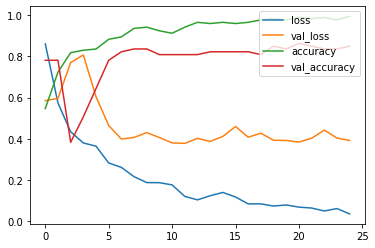

Confusion Matrix: 
[[71 11]
 [ 9 14]]
Validation Accuracy: 80.95%
Validation Sensitivity: 60.87%
Validation Specificity: 86.59%
Validation Balanced accuracy: 73.73%
Validation AUC: 0.8118


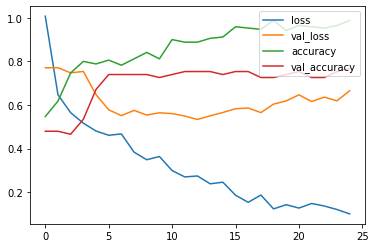

Confusion Matrix: 
[[35 16]
 [13 41]]
Validation Accuracy: 72.38%
Validation Sensitivity: 75.93%
Validation Specificity: 68.63%
Validation Balanced accuracy: 72.28%
Validation AUC: 0.8253


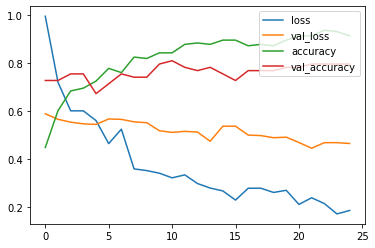

Confusion Matrix: 
[[65 12]
 [10 18]]
Validation Accuracy: 79.05%
Validation Sensitivity: 64.29%
Validation Specificity: 84.42%
Validation Balanced accuracy: 74.35%
Validation AUC: 0.8019


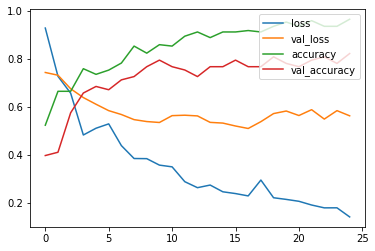

Confusion Matrix: 
[[30 12]
 [ 8 55]]
Validation Accuracy: 80.95%
Validation Sensitivity: 87.30%
Validation Specificity: 71.43%
Validation Balanced accuracy: 79.37%
Validation AUC: 0.9123


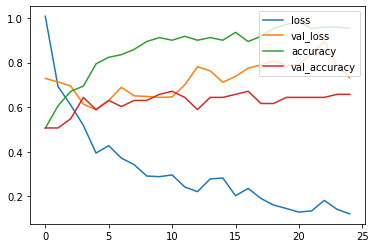

Confusion Matrix: 
[[31 21]
 [11 42]]
Validation Accuracy: 69.52%
Validation Sensitivity: 79.25%
Validation Specificity: 59.62%
Validation Balanced accuracy: 69.43%
Validation AUC: 0.7950


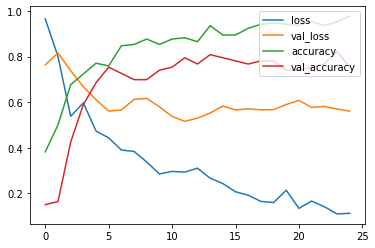

Confusion Matrix: 
[[85  4]
 [11  5]]
Validation Accuracy: 85.71%
Validation Sensitivity: 31.25%
Validation Specificity: 95.51%
Validation Balanced accuracy: 63.38%
Validation AUC: 0.7416
Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25


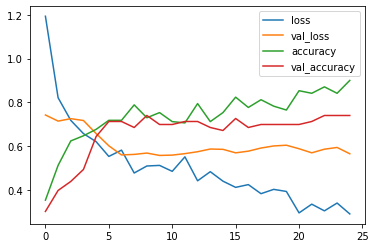

Confusion Matrix: 
[[56 17]
 [14 18]]
Validation Accuracy: 70.48%
Validation Sensitivity: 56.25%
Validation Specificity: 76.71%
Validation Balanced accuracy: 66.48%
Validation AUC: 0.7277


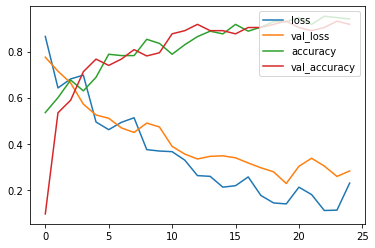

Confusion Matrix: 
[[87  8]
 [ 6  4]]
Validation Accuracy: 86.67%
Validation Sensitivity: 40.00%
Validation Specificity: 91.58%
Validation Balanced accuracy: 65.79%
Validation AUC: 0.8295


In [112]:
auc_scores = []
for i in range(len(one_hot_labels)):
    Y = Multi_y[:,i]
    y = one_hot_labels[i]
    Train_X, test_X, Train_Y, test_Y = train_test_split(X, y, test_size=0.3,stratify=y,random_state=0, shuffle=True)
    #划分验证集并调整classweight
    test_y = test_Y[:,1]
    train_X, val_X, train_Y, val_Y = train_test_split(Train_X, Train_Y, test_size=0.3,stratify=Train_Y,random_state=42, shuffle=True)
#labelValue = {'S': 0,'Cip': 1, 'Ery': 2,'Tet': 3,'Amp': 4,'Kana': 5,'Strep': 6,'Gent': 7}
    #model params
    if i == 3:
        clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],units=[4, 6, 24],batch_size=32,
                                           dropout=0.15,epochs=25,verbose=0,gpuid=7)
    elif i == 5:
        clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64,64],units=[4, 6, 24],batch_size=32,
                                           dropout=0.1,epochs=25,verbose=0,gpuid=7)
    elif i == 6:
        clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64,32],units=[4, 12, 24],batch_size=32,
                                           dropout=0.15,epochs=25,verbose=20,gpuid=7)
    elif i == 7:
        clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64,32],units=[4, 12, 12],batch_size=32,
                                           dropout=0.15,epochs=25,verbose=0,gpuid=7)
    else:
        clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],units=[4, 24, 24],batch_size=32,
                                       dropout=0.15,epochs=25,verbose=0,gpuid=7)
    
    clf.fit(train_X, train_Y, X_val = val_X, y_val = val_Y,
            class_weights=dict(enumerate(class_weight.compute_class_weight('balanced', [0, 1], train_Y[:, 1]))))
    y_pro = clf.predict_proba(test_X)
    y_raw = 0 * y_pro[:, 0] + 1 * y_pro[:, 1]
    y_pred = np.argmax(y_pro, axis=1)

    #plot train curve
    PlotCurve(clf.history)

    #MADLINet Test Metrics
    Overall_accuracy = accuracy_score(test_y, y_pred)
    conf_matrix = confusion_matrix(test_y, y_pred,labels=[0,1])
    Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
    Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    Balanced_accuracy = balanced_accuracy_score(test_y, y_pred)
    AUC = roc_auc_score(test_y, y_raw)
    auc_scores.append(AUC)

    print('Confusion Matrix: ')
    print(conf_matrix)
    print("Validation Accuracy: {:5.2f}%".format(Overall_accuracy*100))
    print('Validation Sensitivity: {:5.2f}%'.format(Sensitivity*100))
    print('Validation Specificity: {:5.2f}%'.format(Specificity*100))
    print('Validation Balanced accuracy: {:5.2f}%'.format(Balanced_accuracy*100))
    print('Validation AUC: {:5.4f}'.format(AUC))

In [113]:
valueLabel = {value: key for key, value in labelValue.items()}
for i in range(len(auc_scores)):
    print(f'{valueLabel.get(i)} auc is {auc_scores[i]}')
print('Mean AUC = ',np.mean(auc_scores))

S auc is 0.8117709437963945
Cip auc is 0.8253449527959333
Ery auc is 0.801948051948052
Tet auc is 0.9123204837490552
Amp auc is 0.7949927431059506
Kana auc is 0.7415730337078652
Strep auc is 0.7277397260273972
Gent auc is 0.8294736842105264
Mean AUC =  0.8056454524176468
